Upload Gambar CONTENT:


Saving WhatsApp Image 2025-11-25 at 11.37.15.jpeg to WhatsApp Image 2025-11-25 at 11.37.15 (1).jpeg
Upload Gambar STYLE:


Saving WhatsApp Image 2025-11-25 at 11.37.11.jpeg to WhatsApp Image 2025-11-25 at 11.37.11 (1).jpeg


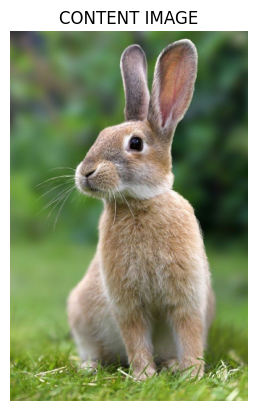

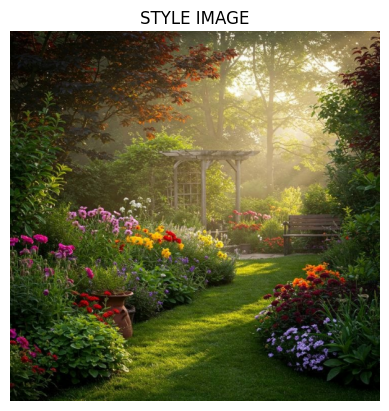

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training dimulai...

Epoch 1/10 selesai
Epoch 2/10 selesai
Epoch 3/10 selesai
Epoch 4/10 selesai
Epoch 5/10 selesai
Epoch 6/10 selesai
Epoch 7/10 selesai
Epoch 8/10 selesai
Epoch 9/10 selesai
Epoch 10/10 selesai

Training selesai dalam 5626.51 detik


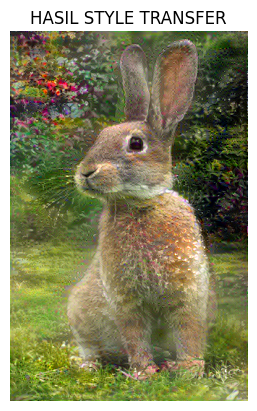


HASIL DISIMPAN SEBAGAI: hasil_style_transfer.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# ================================================
#  Natural Style Transfer - FULL CODE (1 FILE)
# ================================================

# ------------------------------
# 1. IMPORT LIBRARY
# ------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from google.colab import files

# ------------------------------
# 2. FUNGSI LOAD & TAMPILKAN GAMBAR
# ------------------------------
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    return img[tf.newaxis, :]

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------------------
# 3. UPLOAD GAMBAR
# ------------------------------
print("Upload Gambar CONTENT:")
content_upload = files.upload()

print("Upload Gambar STYLE:")
style_upload = files.upload()

content_path = list(content_upload.keys())[0]
style_path = list(style_upload.keys())[0]

content_image = load_img(content_path)
style_image = load_img(style_path)

imshow(content_image, "CONTENT IMAGE")
imshow(style_image, "STYLE IMAGE")

# ------------------------------
# 4. SETTING MODEL VGG19
# ------------------------------
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1','block2_conv1','block3_conv1',
    'block4_conv1','block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model([vgg.input], outputs)

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    shape = tf.shape(input_tensor)
    num_locations = tf.cast(shape[1] * shape[2], tf.float32)
    return result / num_locations

# ------------------------------
# 5. MODEL STYLE & CONTENT
# ------------------------------
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed)

        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]

        style_outputs = [gram_matrix(s) for s in style_outputs]

        style_dict = {style_layers[i]: style_outputs[i] for i in range(len(style_outputs))}
        content_dict = {content_layers[i]: content_outputs[i] for i in range(len(content_outputs))}

        return {'style': style_dict, 'content': content_dict}

# ------------------------------
# 6. MODEL & OPTIMIZER
# ------------------------------
extractor = StyleContentModel(style_layers, content_layers)
opt = tf.optimizers.Adam(learning_rate=0.02)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

style_weight = 1e-2
content_weight = 1e4

# ------------------------------
# 7. LOSS FUNCTION
# ------------------------------
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers

    return style_loss + content_loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# ------------------------------
# 8. TRAINING STYLE TRANSFER
# ------------------------------
import time
image = tf.Variable(content_image)

epochs = 10
steps_per_epoch = 100

print("Training dimulai...\n")
start = time.time()

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    print(f"Epoch {n+1}/{epochs} selesai")

end = time.time()
print("\nTraining selesai dalam", round(end - start, 2), "detik")

imshow(image, "HASIL STYLE TRANSFER")

# ------------------------------
# 9. SIMPAN HASIL
# ------------------------------
file_name = "hasil_style_transfer.jpg"
tensor = image * 255
tensor = np.array(tensor, dtype=np.uint8)
tensor = tensor.squeeze()
img = PIL.Image.fromarray(tensor)
img.save(file_name)

print("\nHASIL DISIMPAN SEBAGAI:", file_name)
files.download(file_name)